In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
%cd gdrive/MyDrive/iss

/content/gdrive/MyDrive/iss


In [ ]:
!pip install transformers

In [ ]:
import pandas as pd
import torch.utils.data as Data
from torch.optim.lr_scheduler import StepLR
import torch
from transformers import AutoModel, AutoTokenizer 
from torch.utils.data import Dataset
import argparse
import os
import copy
import numpy as np
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from math import sqrt
from tqdm.notebook import tqdm
from datetime import datetime
import matplotlib.pyplot as plt

In [ ]:
EPOCHS = 10
SEED = 2021
BERT = 'DeepPavlov/rubert-base-cased'
MAX_LENGTH = 200
BATCH_SIZE = 8

In [ ]:
def rmse(y, y_pred):
    return sqrt(mean_squared_error(y, y_pred))

In [ ]:
class CustomDataset(Dataset):

    def __init__(self, x_train, y_train):
        tokenizer = AutoTokenizer.from_pretrained(BERT)

        sentences = x_train
        labels = y_train

        self.data = [
            (
                tokenizer.encode(sentence, padding='max_length', max_length=MAX_LENGTH, truncation=True),
                label,
            )
            for sentence, label in zip(sentences, labels)
        ]

    def __len__(self):
        return len(self.data)

    def __getitem__(self, index):
        x, y = self.data[index]
        x = torch.tensor(x)
        y = torch.tensor(y, dtype=torch.float)
        return x, y

In [ ]:
class RegressionBert(torch.nn.Module):
    def __init__(self, freeze_bert=True):
        super(RegressionBert, self).__init__()
        self.bert = AutoModel.from_pretrained(BERT, num_labels=1)
        if freeze_bert:
            for p in self.bert.parameters():
                p.requires_grad = False
        self.fc0 = torch.nn.Linear(768, 1)

    def forward(self, x, att=None):
        x = self.bert(x, attention_mask=att)[0]
        x = x[:, 0, :]
        x = self.fc0(x)
        x = x.flatten()
        return x

In [ ]:
def train_one_epoch(model, optimizer, dataset, f_loss, device="cpu"):
    generator = torch.utils.data.DataLoader(
        dataset, batch_size=BATCH_SIZE, shuffle=True
    )
    model.train()
    train_loss, train_acc = 0.0, 0.0
    for batch, labels in tqdm(generator):
        batch, labels = batch.to(device), labels.to(device)
        optimizer.zero_grad()
        preds = model(batch)
        loss = f_loss(preds, labels)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
        train_acc += rmse(preds.cpu().detach(), labels.cpu().detach())
    train_loss /= len(dataset)
    train_acc /= len(dataset)
    return train_loss, train_acc

In [ ]:
def evaluate_one_epoch(model, dataset, f_loss, device="cpu"):
    generator = torch.utils.data.DataLoader(
        dataset, batch_size=BATCH_SIZE, shuffle=True
    )
    model.eval()
    val_loss, val_acc = 0.0, 0.0
    with torch.no_grad():
        for batch, labels in tqdm(generator):
            batch, labels = batch.to(device), labels.to(device)
            preds = model(batch)
            loss = f_loss(preds, labels)
            val_loss += loss.item()
            preds = preds.cpu().detach()
            val_acc += rmse(preds, labels.cpu().detach())
    val_loss /= len(dataset)
    val_acc /= len(dataset)
    return val_loss, val_acc

In [ ]:
def predict_one_epoch(model, dataset, device="cpu"):
    generator = torch.utils.data.DataLoader(
        dataset, batch_size=BATCH_SIZE
    )
    model.eval()
    predictions = []
    with torch.no_grad():
        for batch, labels in tqdm(generator):
            batch = batch.to(device)
            preds = model(batch)
            preds = preds.cpu().detach()
            predictions += preds
    return predictions

In [ ]:
def split_data(X, y):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=SEED)
    return X_train, X_test, y_train, y_test

In [ ]:
df = pd.read_csv("https://storage.yandexcloud.net/nlp-dataset-bucket-1/toloka-vk-proceedings-2020/toloka-vk-raw-unprocessed.tsv", sep='\t',
                 names=['INPUT:text', 'OUTPUT:disgust_rage', 'OUTPUT:fear_surprise', 'OUTPUT:shame_excitement', 'OUTPUT:enjoyment_distress'],
                 index_col=False, header=0)
df = df.dropna(how='all')
df.head()

,INPUT:text,OUTPUT:disgust_rage,OUTPUT:fear_surprise,OUTPUT:shame_excitement,OUTPUT:enjoyment_distress
0,"Приехала в свой родной город на выходные, от з...",2.0,3.0,0.0,2.0
2,У моей мамы два с половиной года назад отказал...,0.0,-4.0,0.0,5.0
4,Два года назад племянника моего мужа сбила маш...,5.0,-2.0,0.0,5.0
6,"Год без секса, но больше всего скучаю не по фи...",0.0,0.0,4.0,1.0
8,На днях узнала что беременна . Мой жених уходи...,0.0,-5.0,-3.0,3.0


In [ ]:
input_col = 'INPUT:text'
outpul_cols = ['OUTPUT:disgust_rage', 'OUTPUT:fear_surprise', 'OUTPUT:shame_excitement', 'OUTPUT:enjoyment_distress']

In [ ]:
df[outpul_cols].values

array([[ 2.,  3.,  0.,  2.],
       [ 0., -4.,  0.,  5.],
       [ 5., -2.,  0.,  5.],
       ...,
       [ 0.,  0.,  0.,  4.],
       [-1., -3., -2.,  4.],
       [-5.,  2., -3.,  3.]])

In [ ]:
df.shape

(3965, 5)

In [ ]:
y = df['OUTPUT:fear_surprise'].values
X = df[input_col]

X_train, X_test, y_train, y_test = split_data(X, y)
X_train, X_val, y_train, y_val = split_data(X_train, y_train)

X_train = X_train.values
X_test = X_test.values
X_val = X_val.values

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [ ]:
def start_work(old_model=None):

    freeze_bert = False
    
    train_stats = []
    val_stats = []

    train_set = CustomDataset(X_train, y_train)
    val_set = CustomDataset(X_val, y_val)
    test_set = CustomDataset(X_test, np.zeros([X_test.shape[0]]))

    model = RegressionBert(freeze_bert).to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-5)
    f_loss = torch.nn.MSELoss()

    best_model = copy.deepcopy(model.state_dict())
    best_val_loss = np.inf

    scheduler = StepLR(optimizer, step_size=30, gamma=0.1)

    print("Start training...")
    for epoch in range(0, EPOCHS):

        train_loss, train_acc = train_one_epoch(model, optimizer, train_set, f_loss, device)
        print("Epoch {}, Train loss: {}, Train RMSE: {}".format(epoch + 1, train_loss, train_acc))

        val_loss, val_acc = evaluate_one_epoch(model, val_set, f_loss, device)
        print("Epoch {}, Val loss: {}, Val RMSE: {}".format(epoch + 1, val_loss, val_acc))

        train_stats.append((train_loss, train_acc))
        val_stats.append((val_loss, val_acc))

        scheduler.step()

        if val_loss < best_val_loss:
            best_val_loss = val_loss
            best_model = copy.deepcopy(model.state_dict())
    print("Finish training")

    model.load_state_dict(best_model)
    
    print("Making predictions...")
    predictions = predict_one_epoch(model, test_set, device)
    predictions = predictions[:X_test.shape[0]]
    predictions = np.array(predictions)

    pd.DataFrame(predictions).to_csv(f"results_{datetime.now()}.csv", index=False, header=False)
    
    #torch.save(model.state_dict(), f"bert_mlingual_model_{datetime.now()}.pth")
    return train_stats, val_stats, pd.DataFrame(predictions)

In [ ]:
%%time
train_stats, val_stats, preds = start_work()


Start training...



Epoch 1, Train loss: 0.724570820296047, Train RMSE: 0.288654225559487



Epoch 1, Val loss: 0.6779298984131464, Val RMSE: 0.28384832641893376



Epoch 2, Train loss: 0.6829665224350813, Train RMSE: 0.28138963451561766



Epoch 2, Val loss: 0.6774293128456943, Val RMSE: 0.279546661148304



Epoch 3, Train loss: 0.5900499034676812, Train RMSE: 0.26180703872861183



Epoch 3, Val loss: 0.7438621550976183, Val RMSE: 0.293237256399861



Epoch 4, Train loss: 0.49206304234039155, Train RMSE: 0.23782003598533785



Epoch 4, Val loss: 0.6550019199133706, Val RMSE: 0.2750312952668259



Epoch 5, Train loss: 0.3567719782878147, Train RMSE: 0.20256703127909176



Epoch 5, Val loss: 0.7034411472218091, Val RMSE: 0.283760332373428



Epoch 6, Train loss: 0.26299190063156136, Train RMSE: 0.17385560759061844



Epoch 6, Val loss: 0.7936777792343286, Val RMSE: 0.30307422618066127



Epoch 7, Train loss: 0.18541017223061299, Train RMSE: 0.1457109456943638



Epoch 7, Val loss: 0.7377144398809481, Val RMSE: 0.29269926157502435



Epoch 8, Train loss: 0.13468548468669952, Train RMSE: 0.12322376279684216



Epoch 8, Val loss: 0.7881410392750354, Val RMSE: 0.2991636272535198



Epoch 9, Train loss: 0.09068249558490901, Train RMSE: 0.1013735225204187



Epoch 9, Val loss: 0.7605658285901183, Val RMSE: 0.2972681718653479



Epoch 10, Train loss: 0.07030693110151467, Train RMSE: 0.08949628657642247



Epoch 10, Val loss: 0.7457454639608834, Val RMSE: 0.29663657983808045
Finish training
Making predictions...



CPU times: user 10min 11s, sys: 7min 13s, total: 17min 25s
Wall time: 17min 58s


In [ ]:
rmse(preds, y_test)

2.3033663291658217

In [ ]:
def plot_target(y_train, y_test, label_1='y_train', label_2='y_test'):
    fig, ax = plt.subplots()
    pd.DataFrame(y_train).hist(ax=ax, bins=100)
    y_test.hist(ax=ax, bins=100)
    ax.set_yscale('log')
    ax.legend([label_1, label_2])

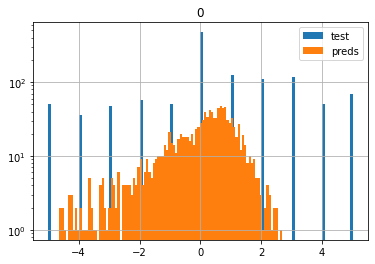

In [ ]:
plot_target(y_test, preds, 'test', 'preds')

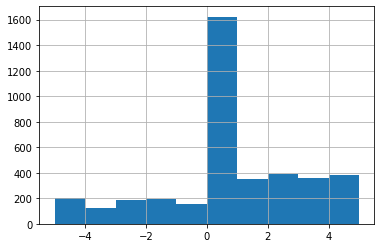

In [ ]:
df['OUTPUT:fear_surprise'].hist()

In [ ]:
train_rmse = [item[1] for item in train_stats]
val_rmse = [item[1] for item in val_stats]

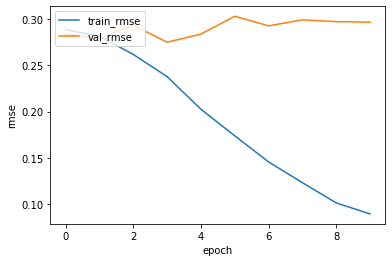

In [ ]:
plt.plot(train_rmse)
plt.plot(val_rmse)
plt.ylabel('rmse')
plt.xlabel('epoch')
plt.legend(['train_rmse', 'val_rmse'], loc='upper left')
plt.show()